In [1]:
import csv
import os
import random
import numpy as np
import pandas as pd
random.seed(42)

from const import *
from visualisation import *

# Config Setup
- randomise agent groups (restart kernel and run the file from the start to get the same set of values used in the experiments)
- generate OD matrices

In [2]:
def split_agents(emitter_id, min_receiver_id, max_receiver_id, num_groups):
    # split the groups evenly and assign the emitter to the group with lesser agents
    result = []
    agent_IDs = list(range(min_receiver_id,max_receiver_id+1))

    q, r = divmod(len(agent_IDs), num_groups)
    num_big_groups = r
    big_group_size = q + 1
    num_small_groups = num_groups - r
    small_group_size = q

    for _ in range(num_big_groups):
        group = random.sample(agent_IDs, big_group_size)
        result.append(sorted(group))
        agent_IDs = [i for i in agent_IDs if i not in group]

    for _ in range(num_small_groups):
        group = random.sample(agent_IDs, small_group_size)
        result.append(sorted(group))
        agent_IDs = [i for i in agent_IDs if i not in group]
        
    random.shuffle(result)
    
    min_len = pos = 9999
    for i in range(num_groups):
        if len(result[i]) < min_len:
            min_len = len(result[i])
            pos = i
    result[pos].insert(0, emitter_id)
    return result

In [3]:
experiment_groups = [split_agents(emitter_ID, min_id, max_id, 5) for i in range(3)]
R, S1, T = experiment_groups
T[2], T[4] = T[4], T[2]
S2 = S1.copy()
S3 = S1.copy()
S2[1], S2[2] = S2[2], S2[1]
S3[1], S3[3] = S3[3], S3[1]
experiment_groups = [i for i in (R, S1, S2, S3, T)]
experiment_groups

[[[1, 14, 15, 17, 23, 29],
  [11, 16, 20, 21, 26, 28],
  [3, 4, 12, 18, 27, 30],
  [6, 7, 8, 13, 19, 24],
  [2, 5, 9, 10, 22, 25]],
 [[3, 15, 16, 21, 27, 28],
  [1, 2, 9, 11, 20, 23],
  [7, 13, 14, 19, 22, 25],
  [4, 5, 17, 18, 24, 29],
  [6, 8, 10, 12, 26, 30]],
 [[3, 15, 16, 21, 27, 28],
  [7, 13, 14, 19, 22, 25],
  [1, 2, 9, 11, 20, 23],
  [4, 5, 17, 18, 24, 29],
  [6, 8, 10, 12, 26, 30]],
 [[3, 15, 16, 21, 27, 28],
  [4, 5, 17, 18, 24, 29],
  [7, 13, 14, 19, 22, 25],
  [1, 2, 9, 11, 20, 23],
  [6, 8, 10, 12, 26, 30]],
 [[6, 7, 13, 15, 21, 23],
  [4, 17, 19, 20, 25, 30],
  [8, 11, 18, 26, 27, 28],
  [5, 9, 10, 14, 16, 29],
  [1, 2, 3, 12, 22, 24]]]

In [4]:
def prepare_ODmatrix(template_filepath, agent_group: list[list[int]], output_filepath):
    # read from template
    with open(template_filepath, 'r', newline='') as file:
        reader = csv.DictReader(file, delimiter=';')
        rows = list(reader)
        
    # change values to 1
    for orig, dest in zip(agent_group, TARGETS):
        print(f"agents: {orig} | initial target: {dest}")
        if dest == "table":
            for o in orig:
                # print(f"row: {o-1} | col: {o+130}")
                rows[o-1][str(o+130)] = 1 # 101 -> 131; 102 -> 132; etc...
        else:
            for o in orig:
                # print(f"row: {o-1} | col: {TARGETS_ID[dest]}")
                rows[o-1][str(TARGETS_ID[dest])] = 1
                
    # write to new file
    with open(output_filepath, 'w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=reader.fieldnames, delimiter=';')
        writer.writeheader()
        writer.writerows(rows)

In [5]:
# restart kernel and run the file from the start the get the same set of values used in the experiments

n_trials = 30
template_filepath = 'Experiments/traj_input/ODMatrix_template.csv'


# create 5 OD matrix for 5 expt variation
files = os.listdir('Experiments/traj_input')
count = 0
for f in files:
    if f.startswith("ODMatrix_Expt"):
        count += 1

if count >= 5:
    print("OD matrices already generated")
else:
    for i, t in enumerate(TARGETS): # for each experiment
        print("#"*130)
        groups = experiment_groups[i]
        if "restroom" == t:
            print(f"Expt {i+1}: Emitter target = '{t}'")
            output_filepath = f'Experiments/traj_input/ODMatrix_Expt1.csv'
        elif "subgroup" in t:
            print(f"Expt 2.{i}: Emitter target = '{t}'")
            output_filepath = f'Experiments/traj_input/ODMatrix_Expt2.{i}.csv'
        else: 
            print(f"Expt {i+1}: Emitter target = '{t}'")
            output_filepath = f'Experiments/traj_input/ODMatrix_Expt3.csv'
        prepare_ODmatrix(template_filepath, groups, output_filepath)
        print()

OD matrices already generated


Run the simulations in momenTUMv2
1. Expt1 -> 30 trials
2. Expt2 -> 10 trials for each sub-experiment
3. Expt3 -> 30 trials
- rename any files appropriately

# Section 4.2 Data Analysis of Passive Scalar Estimation

In [7]:
# DIR = "./Experiments/fig"


##### Expt 1 #####
n_sim = 30
ps_model_file = "./passive_scalar_data/data_model_emitter_standing_receiver_standing.p"
traj_filepaths = [f"./Experiments/traj_output/Expt1.{i:02}_pedestrian.csv" for i in range(1,n_sim+1)]
npy_filepaths = [f"./Experiments/ps_output/Expt1.{i:02}_ps.npy" for i in range(1,n_sim+1)]

print("Experiment 1")

output_npy_files_expt1 = get_ps_arrays(ps_model_file, traj_filepaths, npy_filepaths)
avg_data_expt1 = get_avg_data(output_npy_files_expt1)
agent_data_expt1 = get_agg_agent_data(output_npy_files_expt1)
timestep_data_expt1 = get_agg_timestep_data(output_npy_files_expt1)


##### Expt 2 #####
n_sim = 10
ps_model_file = "./passive_scalar_data/data_model_emitter_standing_receiver_standing.p"
traj_filepaths = [f"./Experiments/traj_output/Expt2.{j}.{i:02}_pedestrian.csv" for j in range(1,4) for i in range(1,n_sim+1)]
npy_filepaths = [f"./Experiments/ps_output/Expt2.{i:02}_ps.npy" for i in range(1,31)]

print("Experiment 2")

output_npy_files_expt2 = get_ps_arrays(ps_model_file, traj_filepaths, npy_filepaths)
avg_data_expt2 = get_avg_data(output_npy_files_expt2)
agent_data_expt2 = get_agg_agent_data(output_npy_files_expt2)
timestep_data_expt2 = get_agg_timestep_data(output_npy_files_expt2)


##### Expt 3 #####
n_sim = 30
ps_model_file = "./passive_scalar_data/data_model_emitter_standing_receiver_standing.p"
traj_filepaths = [f"./Experiments/traj_output/Expt3.{i:02}_pedestrian.csv" for i in range(1,n_sim+1)]
npy_filepaths = [f"./Experiments/ps_output/Expt3.{i:02}_ps.npy" for i in range(1,n_sim+1)]

print("Experiment 3")

output_npy_files_expt3 = get_ps_arrays(ps_model_file, traj_filepaths, npy_filepaths)
avg_data_expt3 = get_avg_data(output_npy_files_expt3)
agent_data_expt3 = get_agg_agent_data(output_npy_files_expt3)
timestep_data_expt3 = get_agg_timestep_data(output_npy_files_expt3)

Experiment 1
30 npy files loaded
Experiment 2
30 npy files loaded
Experiment 3
30 npy files loaded


## Figure 4-8: Box plot of ps for each experiment

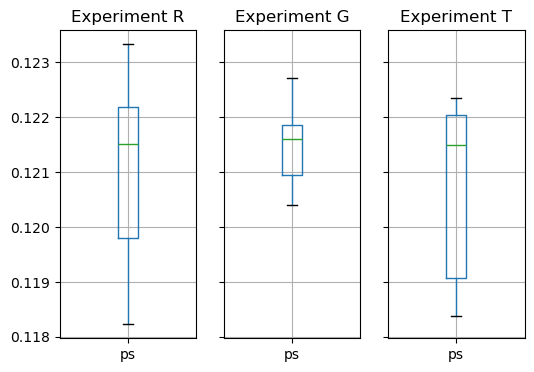

In [8]:
dataframes = [agent_data_expt1, agent_data_expt2, agent_data_expt3]

fig, axes = plt.subplots(nrows=1, ncols=len(dataframes), figsize=(6, 4), sharey=True)
expt_names = ('R','G', 'T')
for i, df in enumerate(dataframes):
    df.drop(columns=['id', 'eu_dist']).boxplot(ax=axes[i])
    axes[i].set_title(f'Experiment {expt_names[i]}')

plt.show()

## Table 4-1: Mean and standard deviation of ps for each experiment

In [9]:
dataframes = [agent_data_expt1, agent_data_expt2, agent_data_expt3]
arr = np.zeros((3,3))

for i, df in enumerate(dataframes):
    df = df.drop(columns=['id', 'eu_dist'])
    arr[i, 1] = df.mean().item()
    arr[i, 2] = df.std().item()

stats_df = pd.DataFrame(arr, columns=['experiment', 'mean', 'std'])
stats_df['experiment'] = expt_names
stats_df

,experiment,mean,std
0,R,0.120946,0.001788
1,G,0.121497,0.000677
2,T,0.120590,0.001597


## Table 4-2: Correlation between ps and eu_dist for each experiment

In [10]:
dfs = (avg_data_expt1, avg_data_expt2, avg_data_expt3)
dfs_data = [df.drop(columns=['timeStep', 'id']) for df in dfs]
arr = np.zeros((3,2))

for i, df in enumerate(dfs_data):
    arr[i, 1] = df.corr().loc['ps', 'eu_dist']

corr_df = pd.DataFrame(arr, columns=['experiment', 'corr'])
corr_df['experiment'] = ('R', 'G', 'T')
corr_df

,experiment,corr
0,R,-0.541359
1,G,0.026874
2,T,-0.918105


## Figure 4-9: Time series of average ps in each timestep across three experiments

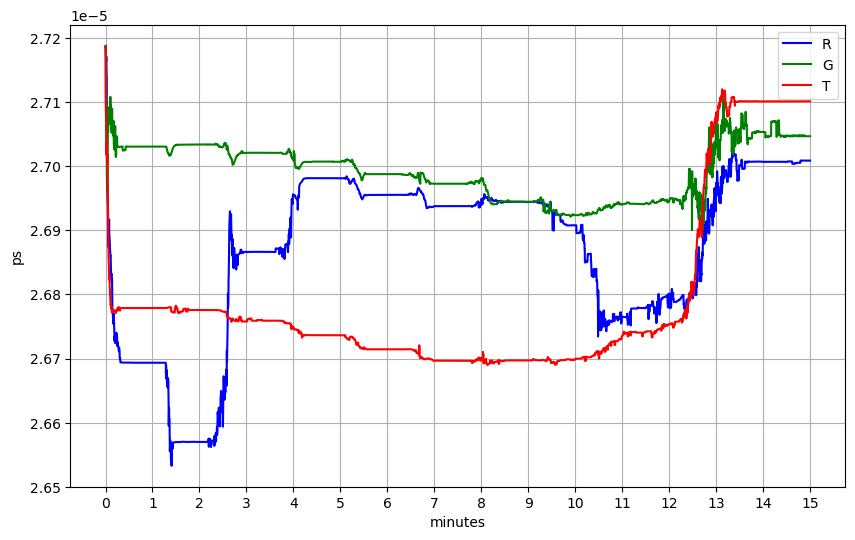

In [11]:
df_list = [timestep_data_expt1,timestep_data_expt2, timestep_data_expt3]

expt_name = ("R", "G", "T")
expt_color = ("b", "g", "r")
num_entry = len(df_list[0])
fig, ax = plt.subplots(figsize=(10, 6))

# plot ps on y-axis
for i, df in enumerate(df_list):
    ax.plot(df["timeStep"], df["ps"], label=expt_name[i], color=expt_color[i])
ax.set_xlabel("minutes")
ax.set_ylabel("ps")
ax.tick_params(axis="y")

# x axis for minutes
ax.set_xticks(range(0, num_entry, num_entry * writer_freq // 60))
ax.set_xticklabels(range(0, 60 // writer_freq + 1, 1))

plt.legend()
plt.grid(True)
plt.show()

## Table 4-3: Top 10 agents’ average ps for each experiment

In [25]:
for df, expt_groups in zip((agent_data_expt1, agent_data_expt2, agent_data_expt3), (experiment_groups[0], experiment_groups[1], experiment_groups[4])):
    group_to_id = {
        "restroom": expt_groups[0], 
        "subgroup": expt_groups[1] + expt_groups[2] + expt_groups[3], 
        "table": expt_groups[4]
    }
    groupping = []
    for i in range(29):
        for k,v in group_to_id.items():
            if i+2 in v:
                groupping.append(k)

    if len(df.columns) == 3:
        df.insert(3, 'group', groupping)

    df_sorted = df.sort_values(by='ps', ascending=False).drop(columns=['eu_dist'])
    df_sorted = df_sorted.rename(columns={'group': 'initial target'})
    display(df_sorted.head(10))

,id,ps,initial target
18,20,0.123326,subgroup
9,11,0.123314,subgroup
24,26,0.123203,subgroup
19,21,0.123191,subgroup
14,16,0.123071,subgroup
26,28,0.123021,subgroup
13,15,0.122316,restroom
27,29,0.122182,restroom
12,14,0.122098,restroom
0,2,0.121876,table


,id,ps,initial target
13,15,0.122705,restroom
14,16,0.122675,restroom
25,27,0.122514,restroom
5,7,0.122248,subgroup
26,28,0.122154,restroom
17,19,0.121985,subgroup
8,10,0.121859,table
10,12,0.121858,table
4,6,0.121852,table
11,13,0.121848,subgroup


,id,ps,initial target
0,2,0.122354,table
1,3,0.122317,table
10,12,0.122241,table
18,20,0.122086,subgroup
28,30,0.122072,subgroup
2,4,0.122064,subgroup
15,17,0.122063,subgroup
22,24,0.122039,table
20,22,0.122026,table
23,25,0.122018,subgroup


## Table 4-4: Average ps for each agent group in each experiment

In [26]:
def modify_experiment_groups(experiment_groups):
    return (experiment_groups[:2] + [experiment_groups[4]]).copy()

def modify_output_arrays(npy_arrays, group):
    agent_npy_list = []
    for arr in npy_arrays:
        arr[:, 1] = arr[:, 1] % num_agents
        loaded_df = pd.DataFrame(arr, columns=output_col)
        loaded_df.loc[loaded_df["id"] == 0, "id"] = 30
        loaded_df = loaded_df[loaded_df["id"].isin(group)]
        agent_npy = loaded_df.groupby(["id"], as_index=False).agg(
            {"ps": "sum", "eu_dist": "mean"}
        ).to_numpy()
        agent_npy_list.append(agent_npy)
    agent_npy_stack = np.stack(agent_npy_list, axis=0)
    agent_data = np.mean(agent_npy_stack, axis=0)
    agent_data = pd.DataFrame(agent_data, columns=output_col[1:]).astype({"id": int})
    return agent_data

def merge_groups(L):
    return [item for sublist in L for item in sublist]

In [27]:
expt_groups = modify_experiment_groups(experiment_groups)

agent_data = []
for i, (output_files, groups) in enumerate(zip([output_npy_files_expt1, output_npy_files_expt2, output_npy_files_expt3], expt_groups)):
    expt_data = []
    expt_data.append(modify_output_arrays(output_files, groups[0]))
    expt_data.append(modify_output_arrays(output_files, merge_groups(groups[1:4])))
    expt_data.append(modify_output_arrays(output_files, groups[4]))
    agent_data.append(expt_data)

targets = ('restroom', 'subgroup', 'table')
index_targets = {0: "restroom (R)", 1: "subgroup (G)", 2: "table (T)"}
arr = np.zeros((3, 3))

for i, df_list in enumerate(agent_data):
    for j, df in enumerate(df_list):
        arr[j, i] = round(df['ps'].mean().item(), 4)

sum_df = pd.DataFrame(arr, columns=targets).rename(index=index_targets)
display(sum_df)

,restroom,subgroup,table
restroom (R),0.1016,0.1222,0.1214
subgroup (G),0.1204,0.1144,0.1199
table (T),0.1217,0.1218,0.1018


# Section 4.3.2 Framework Integration Evaluation - Performance

## Average Simulation Runtime

In [19]:
import timeit
from data_processing import process_traj_data

ps_model_file = "./passive_scalar_data/data_model_emitter_standing_receiver_standing.p"
traj_test = "traj_test.csv"
npy_test = "npy_test.npy"

def run_function():
    process_traj_data(ps_model_file, traj_test, npy_test)

runtime = timeit.timeit(run_function, number=3)
print("Runtime:", runtime / 3, "seconds")

Frames to process: 4500

Frames processed: 0
Frames processed: 500
Frames processed: 1000
Frames processed: 1500
Frames processed: 2000
Frames processed: 2500
Frames processed: 3000
Frames processed: 3500
Frames processed: 4000
Frames processed: 4500

Finished processing.
Output saved to: npy_test.npy
Frames to process: 4500

Frames processed: 0
Frames processed: 500
Frames processed: 1000
Frames processed: 1500
Frames processed: 2000
Frames processed: 2500
Frames processed: 3000
Frames processed: 3500
Frames processed: 4000
Frames processed: 4500

Finished processing.
Output saved to: npy_test.npy
Frames to process: 4500

Frames processed: 0
Frames processed: 500
Frames processed: 1000
Frames processed: 1500
Frames processed: 2000
Frames processed: 2500
Frames processed: 3000
Frames processed: 3500
Frames processed: 4000
Frames processed: 4500

Finished processing.
Output saved to: npy_test.npy
Runtime: 5.218636766667866 seconds


## Figure 4-10: Profile output of data processing function sorted by cumulative time

In [20]:
import cProfile
from data_processing import process_traj_data

ps_model_file = "./passive_scalar_data/data_model_emitter_standing_receiver_standing.p"
traj_test = "traj_test.csv"
npy_test = "npy_test.npy"

func = "process_traj_data(ps_model_file, traj_test, npy_test)"
g = {
    'process_traj_data': process_traj_data,
    'ps_model_file': ps_model_file,
    'traj_test': traj_test,
    'npy_test': npy_test,
}

cProfile.runctx(func, g, {}, sort='cumtime')

Frames to process: 4500

Frames processed: 0
Frames processed: 500
Frames processed: 1000
Frames processed: 1500
Frames processed: 2000
Frames processed: 2500
Frames processed: 3000
Frames processed: 3500
Frames processed: 4000
Frames processed: 4500

Finished processing.
Output saved to: npy_test.npy
         4111422 function calls in 6.290 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    6.579    6.579 {built-in method builtins.exec}
        1    0.001    0.001    6.579    6.579 <string>:1(<module>)
        1    0.125    0.125    6.577    6.577 data_processing.py:92(process_traj_data)
     4501    0.276    0.000    3.911    0.001 data_processing.py:58(compute_ps)
     4501    0.037    0.000    3.151    0.001 sklearn.py:1125(predict)
     4501    2.040    0.000    2.565    0.001 core.py:2310(inplace_predict)
        1    0.206    0.206    1.120    1.120 npyio.py:1742(genfromtxt)
     4501   